# Importación de librerías

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Dense

# Carga de datos

In [179]:
headers = pd.read_csv('../Data/handles-data.csv')
tweets = pd.read_csv('../Data/tweets-data.csv')
pd.options.display.float_format = '{:.2f}'.format

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Target Clasificación

In [180]:
tweets["nretweets"].isnull().sum()

0

In [181]:
tweets["nretweets"].quantile([0.7,0.8,0.9,0.95,1])

0.70       49.00
0.80      104.00
0.90      311.00
0.95      871.00
1.00   541964.00
Name: nretweets, dtype: float64

## Pipeline Target

In [182]:
def pipeline_qcut_label(dataset):
    # very_unpopular:0 unpopular:1 popular:2 very_popular:1
    dataset["categorias"] = pd.qcut(dataset["nretweets"], [0.7,0.8,0.9,0.95,1], labels=["0", "1","2", "3"])
    dataset["categorias"][dataset["categorias"].isnull()] = "0"
    # df = pd.get_dummies(tweets, columns=["categorias"])
    return dataset[["categoria"]]

In [183]:
# tweets_label_categorical = pipeline_qcut_label(tweets)

In [184]:
# tweets_label_categorical

Establezco todos los tweets como poco populares de entrada, así si exiten nulos estos estarán como "poco populares". De esta forma, aquellos tweets que están por debajo o igual al percentil 80 serán como poco populares.

In [185]:
# very_unpopular:0 unpopular:1 popular:2 very_popular:1
tweets["label"] = pd.qcut(tweets["nretweets"], [0.7,0.8,0.90,0.95,1], labels=["0", "1","2", "3"])

In [186]:
tweets["label"][tweets["label"].isnull()] = "0"

In [187]:
tweets["label"].head(8)

0    1
1    2
2    2
3    2
4    3
5    2
6    3
7    0
Name: label, dtype: category
Categories (4, object): ['0' < '1' < '2' < '3']

In [188]:
tweets.groupby('label').size()

label
0    32523
1     4006
2     2023
3     2029
dtype: int64

In [189]:
tweets[tweets["nretweets"]>871]["nretweets"].count()

2029

In [190]:
tweets[tweets["label"]=="3"]["label"].count()

2029

In [191]:
tweets[tweets["nretweets"]<=104]["nretweets"].count()

32523

In [192]:
tweets[tweets["label"]=="0"]["label"].count()

32523

In [193]:
tweets[tweets["label"].isnull()]["label"].count()

0

In [194]:
# tweets_categorical = pd.get_dummies(tweets, columns=["label"])

In [195]:
# tweets_categorical.head()

In [196]:
print(tweets[tweets["label"].isnull()]["label"].count())

0


<AxesSubplot:xlabel='label', ylabel='Count'>

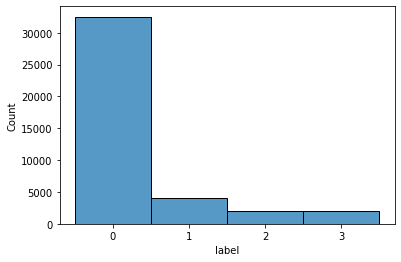

In [197]:
sns.histplot(data=tweets,x=tweets["label"])

# Variables Relevantes

### Unir los datos

In [198]:
union = pd.merge(headers, tweets, left_on='username', right_on='username' )
union.describe()
union.to_csv("../Data/union.csv",sep=";", index=False)

In [199]:
union = pd.read_csv("../Data/union.csv", sep=";")

/home/julianmelero/twitter-ai/twai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Followers

Considerando el análisis inicial de los datos, el número de seguidores (followers), sigue siendo una variable a tener en cuenta para conocer la popularidad de un tweet. En este caso, en vez de tomarlo como numérico, lo pasaremos a categórico.

En primer lugar observamos la dispersión de los datos:

In [200]:
headers["followers"].quantile([0.4,0.5,0.65,0.7,0.8,0.85,0.9,0.95,1])

0.40     3705270.00
0.50     4462139.00
0.65     6345799.50
0.70     7216548.00
0.80    10608102.00
0.85    13958885.50
0.90    18754004.00
0.95    36826698.00
1.00   129909278.00
Name: followers, dtype: float64

Considerando que el primer salto importante se da entre el percentil 60 y 80, empezaremos a dividir los datos por categorías, en este caso en dos. Siendo por ejemplo, número de seguidores "relevante" y "no relevante".

In [201]:
union["followers_categorical"] = pd.qcut(union["followers"], [0.60,0.80,1], labels=["0", "1"])

In [202]:
union["followers_categorical"]

0          1
1          1
2          1
3          1
4          1
        ... 
40862    NaN
40863    NaN
40864    NaN
40865    NaN
40866    NaN
Name: followers_categorical, Length: 40867, dtype: category
Categories (2, object): ['0' < '1']

In [203]:
union["followers_categorical"][union["followers_categorical"].isnull()] = "0"

In [204]:
union[union["followers_categorical"].isnull()]["followers_categorical"].count()

0

<AxesSubplot:xlabel='followers_categorical', ylabel='Count'>

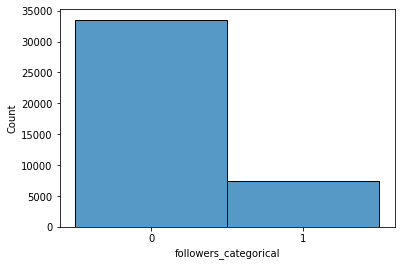

In [205]:
sns.histplot(data=union,x=union["followers_categorical"])

## Tiene URLS

In [206]:
# Si tiene urls
union["have_urls"] = union["urls"] != "[]"


In [207]:
union[union["have_urls"] == True ]["have_urls"].count()

22015

In [171]:
# union["have_urls"].astype(int)

0        0
1        0
2        0
3        1
4        0
        ..
40862    0
40863    0
40864    0
40865    0
40866    0
Name: have_urls, Length: 40867, dtype: int64

In [208]:
union[union["have_urls"] == True ]["have_urls"] = "1"

/tmp/ipykernel_1044/2206091376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  union[union["have_urls"] == True ]["have_urls"] = "1"


In [209]:
union[union["have_urls"] == False ]["have_urls"] = "0"

/tmp/ipykernel_1044/3915545024.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  union[union["have_urls"] == False ]["have_urls"] = "0"


In [247]:
union["have_urls"].unique

<bound method Series.unique of 0        False
1        False
2        False
3         True
4        False
         ...  
40862    False
40863    False
40864    False
40865    False
40866    False
Name: have_urls, Length: 40867, dtype: bool>

<AxesSubplot:xlabel='have_urls', ylabel='Count'>

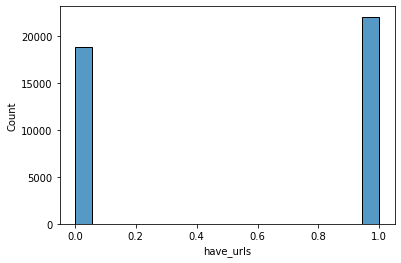

In [245]:

sns.histplot(x=union["have_urls"].astype('bool').astype('int'))
#plt.xticks([0,1])